44Prepare the data
Check the data and its stationarity

In [221]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import r2_score
import os

In [222]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_excel("C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/candlestick_chart_data.xlsx", index_col='Date', parse_dates=['Date'])
pd.set_option('display.max_columns', None)
print(stock_data)

            Opening price  Highest price  Lowest price  Closing price  \
Date                                                                    
2025-01-02            267            303           243            288   
2025-01-03            281            317           270            291   
2025-01-06            278            346           276            327   
2025-01-07            336            388           317            369   
2025-01-08            365            374           303            311   
...                   ...            ...           ...            ...   
2025-06-25             96            114            93            104   
2025-06-26            113            114            94            111   
2025-06-27            106            113            93            111   
2025-06-30            103            113            93            110   
2025-07-01             94            114            93            107   

            Trading volume  Turnover  Median price

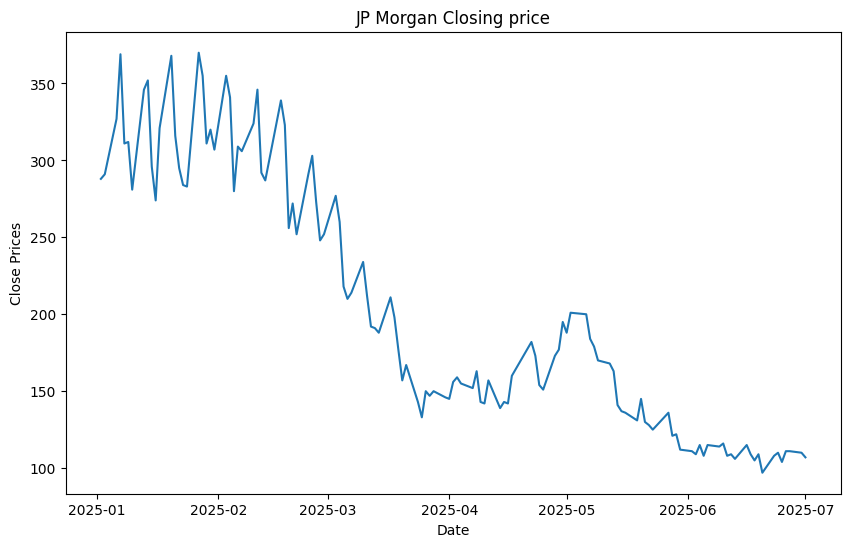

In [223]:
#Visualize the per day closing price of the stock.
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Closing price'])
plt.title('JP Morgan Closing price')
plt.show()


<Axes: ylabel='Density'>

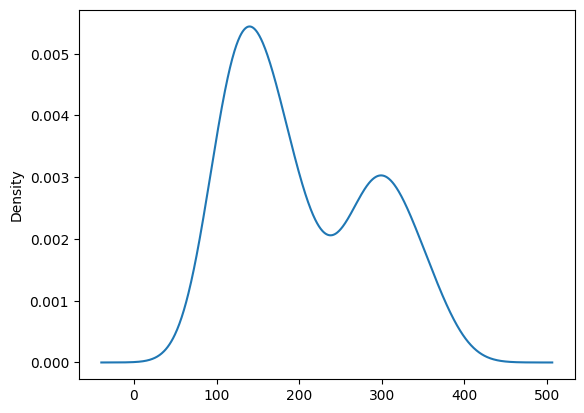

In [224]:
# Distribution of the dataset
df_close=stock_data['Closing price']
df_close.plot(kind='kde')

In [225]:
#Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [226]:
test_stationarity(df_close)

Results for dickey fuller test
Test Statistics                 -0.922090
p-value                          0.780611
No. of lags used                10.000000
Number of observations used    114.000000
critical value (1%)             -3.489058
critical value (5%)             -2.887246
critical value (10%)            -2.580481
dtype: float64


Text(0.5, 1.0, '2 order differencing')

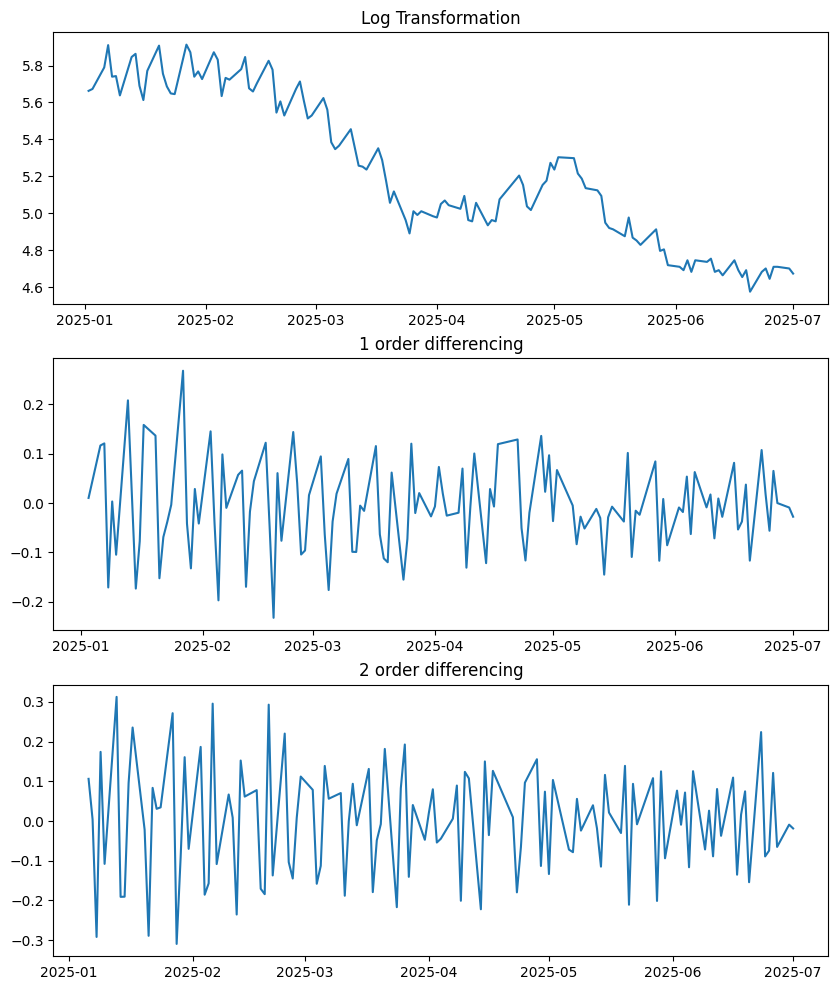

In [227]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_close)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [228]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -3.701667
p-value                          0.004090
No. of lags used                 5.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


In [229]:
test_stationarity(df_diff_2)

Results for dickey fuller test
Test Statistics               -6.966868e+00
p-value                        8.868723e-10
No. of lags used               8.000000e+00
Number of observations used    1.140000e+02
critical value (1%)           -3.489058e+00
critical value (5%)           -2.887246e+00
critical value (10%)          -2.580481e+00
dtype: float64


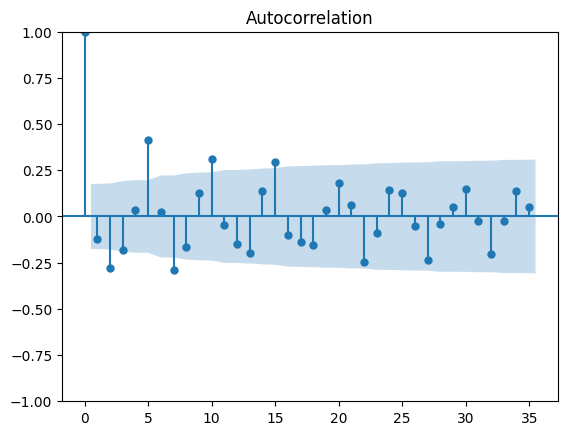

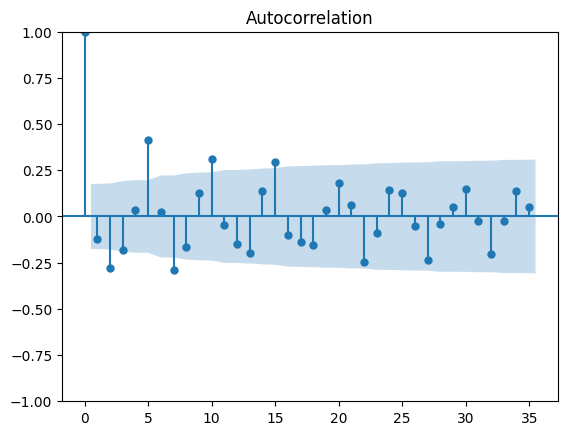

In [230]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

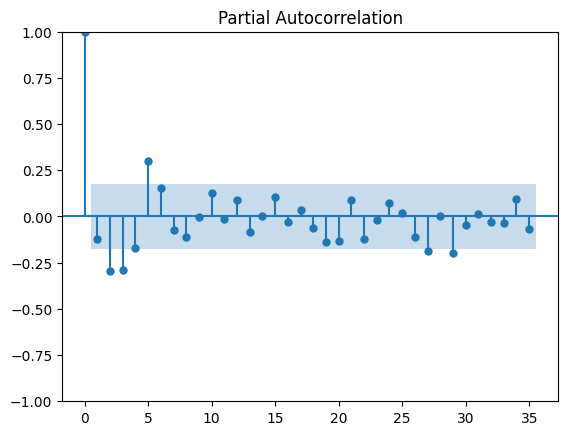

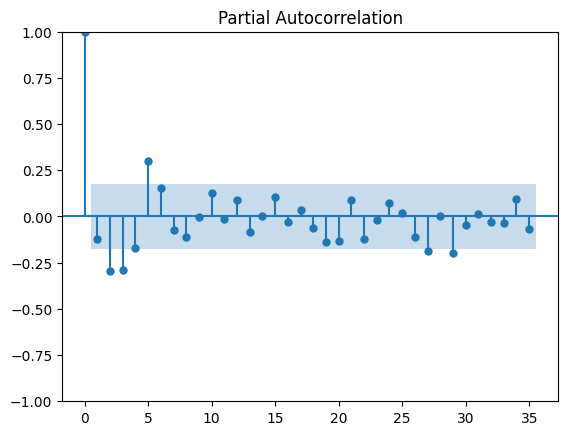

In [231]:
plot_pacf(df_diff,lags=n_lags)

Split data

In [232]:
def train_test_split(df,size=0.7):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15',
               ...
               '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-23',
               '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27',
               '2025-06-30', '2025-07-01'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


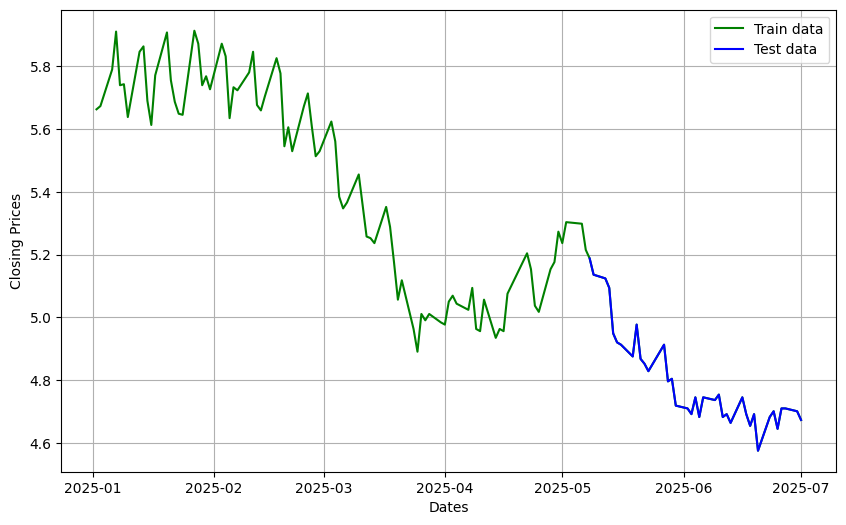

In [233]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.7)

In [234]:
train_data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-04-30    5.273000
2025-05-01    5.236442
2025-05-02    5.303305
2025-05-06    5.298317
2025-05-07    5.214936
Name: Closing price, Length: 87, dtype: float64

In [235]:
test_data

Date
2025-05-08    5.187386
2025-05-09    5.135798
2025-05-12    5.123964
2025-05-13    5.093750
2025-05-14    4.948760
2025-05-15    4.919981
2025-05-16    4.912655
2025-05-19    4.875197
2025-05-20    4.976734
2025-05-21    4.867534
2025-05-22    4.852030
2025-05-23    4.828314
2025-05-27    4.912655
2025-05-28    4.795791
2025-05-29    4.804021
2025-05-30    4.718499
2025-06-02    4.709530
2025-06-03    4.691348
2025-06-04    4.744932
2025-06-05    4.682131
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
2025-06-13    4.663439
2025-06-16    4.744932
2025-06-17    4.691348
2025-06-18    4.653960
2025-06-19    4.691348
2025-06-20    4.574711
2025-06-23    4.682131
2025-06-24    4.700480
2025-06-25    4.644391
2025-06-26    4.709530
2025-06-27    4.709530
2025-06-30    4.700480
2025-07-01    4.672829
Name: Closing price, dtype: float64

Model Selection

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, b

AIC for ARIMA(0,1,0):-150.13151148605894
AIC for ARIMA(0,1,1):-151.0034001769859
AIC for ARIMA(0,1,2):-160.496833591572
AIC for ARIMA(0,1,3):-160.5811892617104
AIC for ARIMA(0,1,4):-161.28358767682664
AIC for ARIMA(0,1,5):-168.83503756930597
AIC for ARIMA(1,1,0):-148.63221540462877
AIC for ARIMA(1,1,1):-154.56626527944485
AIC for ARIMA(1,1,2):-159.4884205522779
AIC for ARIMA(1,1,3):-167.2013854913056
AIC for ARIMA(1,1,4):-165.23104731183932
AIC for ARIMA(1,1,5):-166.94655286383315
AIC for ARIMA(2,1,0):-158.54675135357934
AIC for ARIMA(2,1,1):-162.96760563542924
AIC for ARIMA(2,1,2):-173.73956304911403
AIC for ARIMA(2,1,3):-176.85956809962255
AIC for ARIMA(2,1,4):-174.860015478277
AIC for ARIMA(2,1,5):-171.0582645383348
AIC for ARIMA(3,1,0):-165.14691492636447
AIC for ARIMA(3,1,1):-164.29946903079824
AIC for ARIMA(3,1,2):-175.63597863378908
AIC for ARIMA(3,1,3):-170.69137748096261
AIC for ARIMA(3,1,4):-175.58304282693717
AIC for ARIMA(3,1,5):-174.77182122913337
AIC for ARIMA(4,1,0):-167

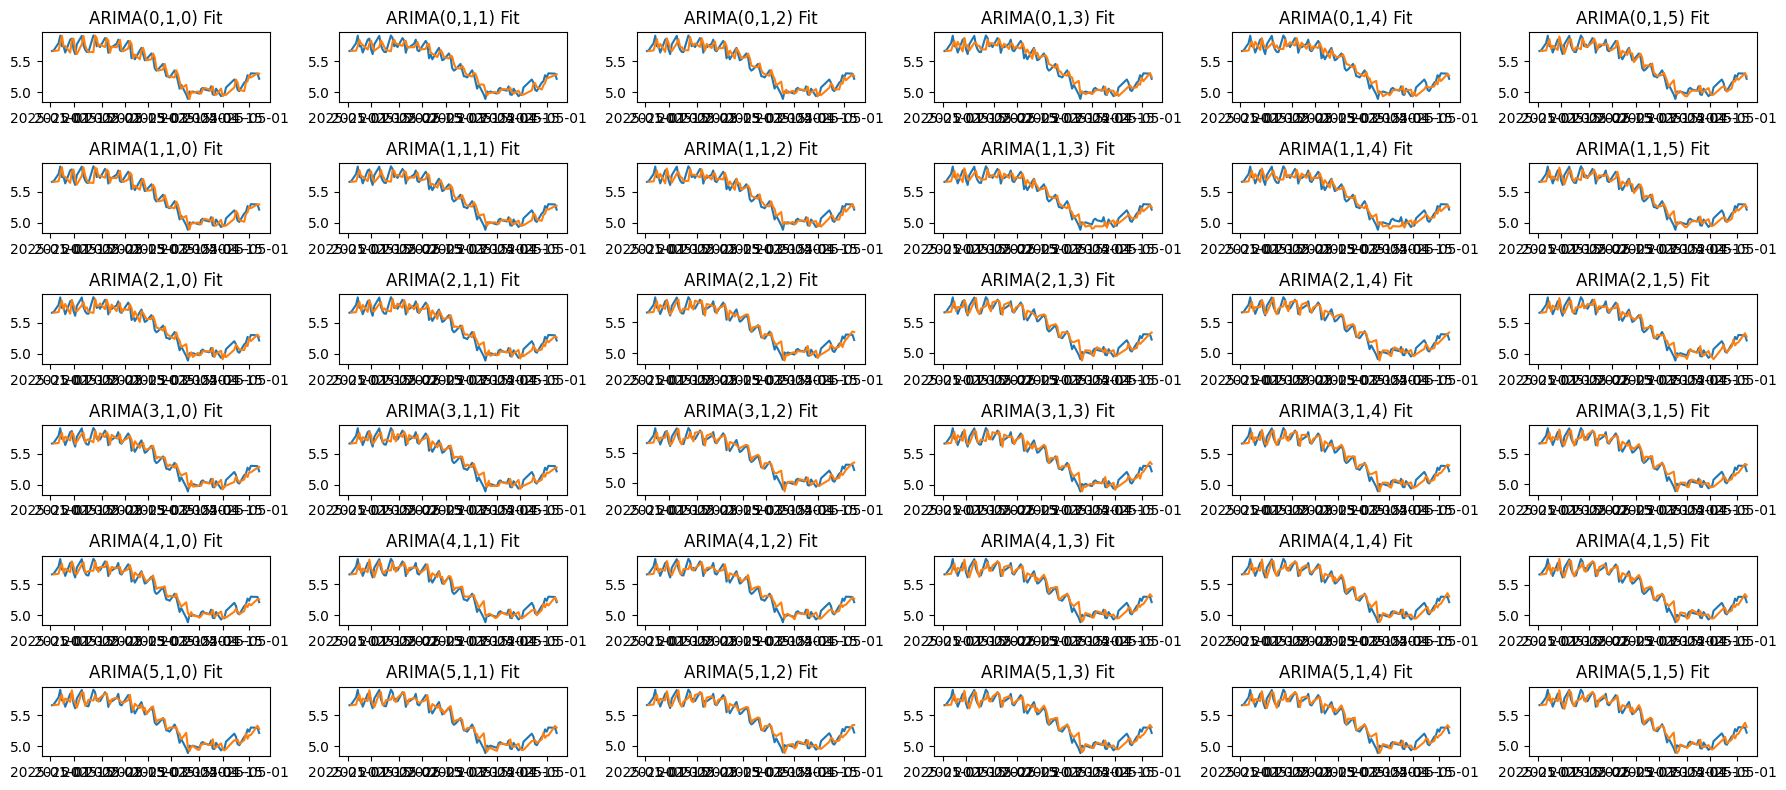

In [236]:
# model selection
ar_orders=[1,2,3,4,5]
ma_orders=[1,2,3,4,5]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [237]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (4,1,3)


Type Markdown and $$Latex:\alpha^{2}$$

Figure(1500x800)


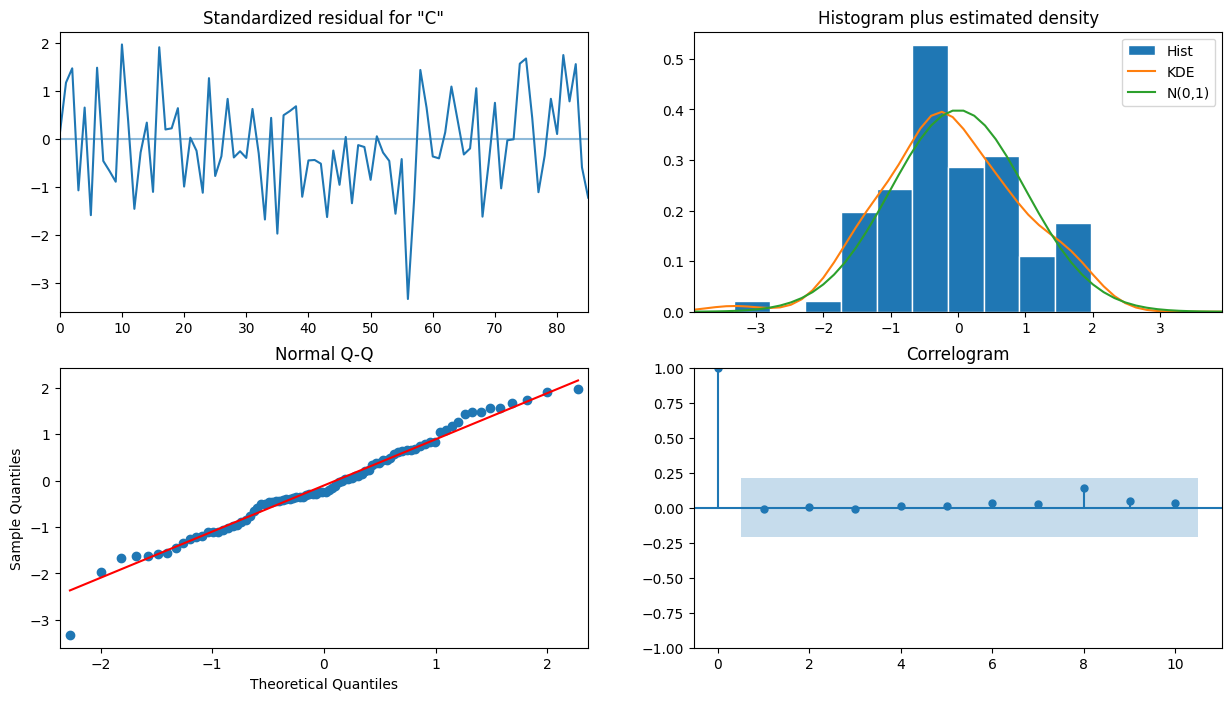

In [238]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

Test the data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-04-30    5.273000
2025-05-01    5.236442
2025-05-02    5.303305
2025-05-06    5.298317
2025-05-07    5.214936
Name: Closing price, Length: 87, dtype: float64
Date
2025-01-02    0.000000
2025-01-03    5.662960
2025-01-06    5.672481
2025-01-07    5.773346
2025-01-08    5.834460
                ...   
2025-04-30    5.138094
2025-05-01    5.175936
2025-05-02    5.182974
2025-05-06    5.343814
2025-05-07    5.309115
Length: 87, dtype: float64


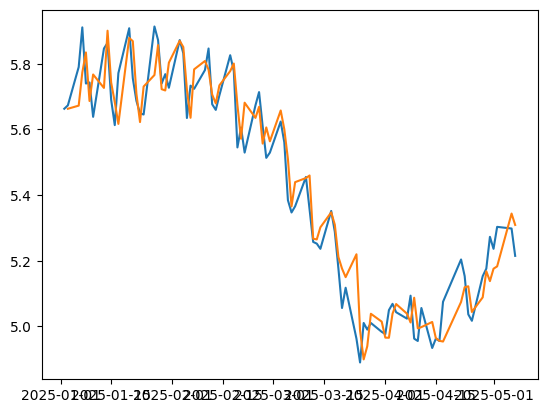

In [239]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[1,1]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [240]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

87     5.255734
88     5.205037
89     5.222283
90     5.246469
91     5.247772
92     5.235473
93     5.212877
94     5.224236
95     5.244056
96     5.249355
97     5.231127
98     5.215787
99     5.225150
100    5.244670
101    5.247526
102    5.229752
103    5.217007
104    5.226782
105    5.244807
106    5.245744
107    5.228755
108    5.218086
109    5.228389
110    5.244699
111    5.244102
112    5.227934
113    5.219190
114    5.229832
115    5.244455
116    5.242562
117    5.227282
118    5.220308
119    5.231110
120    5.244107
121    5.241122
122    5.226790
123    5.221421
124    5.232230
Name: predicted_mean, dtype: float64


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [241]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2025-05-08    5.255734
2025-05-09    5.205037
2025-05-12    5.222283
2025-05-13    5.246469
2025-05-14    5.247772
2025-05-15    5.235473
2025-05-16    5.212877
2025-05-19    5.224236
2025-05-20    5.244056
2025-05-21    5.249355
2025-05-22    5.231127
2025-05-23    5.215787
2025-05-27    5.225150
2025-05-28    5.244670
2025-05-29    5.247526
2025-05-30    5.229752
2025-06-02    5.217007
2025-06-03    5.226782
2025-06-04    5.244807
2025-06-05    5.245744
2025-06-06    5.228755
2025-06-09    5.218086
2025-06-10    5.228389
2025-06-11    5.244699
2025-06-12    5.244102
2025-06-13    5.227934
2025-06-16    5.219190
2025-06-17    5.229832
2025-06-18    5.244455
2025-06-19    5.242562
2025-06-20    5.227282
2025-06-23    5.220308
2025-06-24    5.231110
2025-06-25    5.244107
2025-06-26    5.241122
2025-06-27    5.226790
2025-06-30    5.221421
2025-07-01    5.232230
dtype: float64

<Axes: xlabel='Date'>

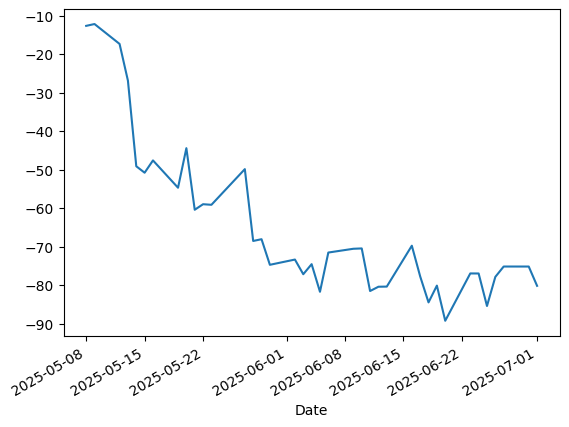

In [242]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 67.91749964507656
MAPE: 0.5648946996331047
MSE: 4612.786758038975
MAE: 64.92370869487866
R^2: -10.667774456858965


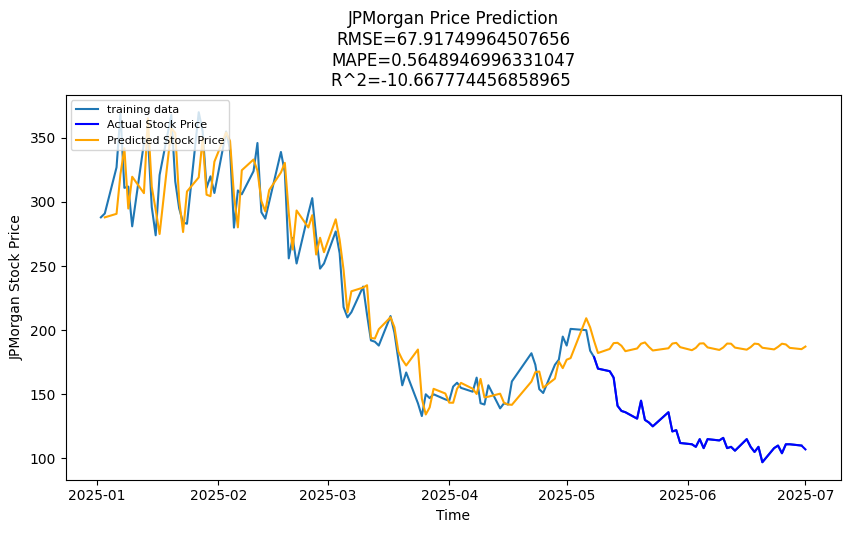

In [255]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
mse = mean_squared_error(np.exp(test_data), np.exp(fc_series))
print('MSE: ' + str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc_series))
print('MAE: ' + str(mae))
r_squared = r2_score(np.exp(test_data), np.exp(fc_series))
print('R^2:', r_squared)
plt.title('JPMorgan Price Prediction\nRMSE=%s\nMAPE=%s\nR^2=%s '%(str(rmse),str(mape),str(r_squared)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Using Auto-ARIMA Model

Rolling Forecasting Origin

In [244]:
# create the model 
from datetime import timedelta
predictions_rolling=pd.Series(dtype=float)
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=auto_arima(train_data, seasonal=False,stepwise=True,suppress_warnings=True,error_action='ignore',max_order=None,trace=False)
    pred = model.predict(n_periods=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model.summary())

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next vers

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 145.587
Date:                Wed, 24 Apr 2024   AIC                           -277.173
Time:                        23:04:04   BIC                           -257.488
Sample:                             0   HQIC                          -269.177
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0122      0.006     -2.116      0.034      -0.024      -0.001
ar.L1          0.5641      0.024     23.933      0.000       0.518       0.610
ar.L2         -0.9825      0.015    -64.014      0.0

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


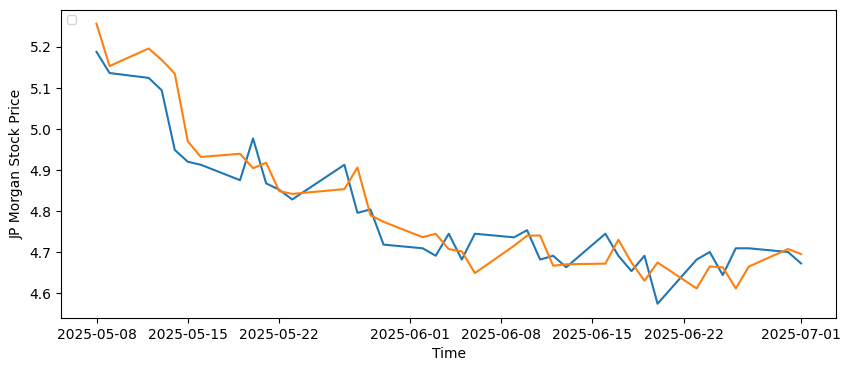

In [245]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('JP Morgan Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [246]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2025-05-08   -12.662160
2025-05-09    -2.902947
2025-05-12   -12.461233
2025-05-13   -12.512024
2025-05-14   -28.770894
2025-05-15    -6.957056
2025-05-16    -2.610084
2025-05-19    -8.691846
2025-05-20    10.130647
2025-05-21    -6.676592
2025-05-22     0.417981
2025-05-23    -1.702135
2025-05-27     7.819478
2025-05-28   -14.105815
2025-05-29     1.728822
2025-05-30    -6.377108
2025-06-02    -3.042883
2025-06-03    -5.985861
2025-06-04     4.224748
2025-06-05    -2.175268
2025-06-06    10.507761
2025-06-09     2.324521
2025-06-10     1.537174
2025-06-11    -6.500729
2025-06-12     2.593887
2025-06-13    -0.762148
2025-06-16     8.063808
2025-06-17    -4.331274
2025-06-18    -2.240515
2025-06-19     6.413298
2025-06-20   -10.225960
2025-06-23     7.329173
2025-06-24     3.806163
2025-06-25    -1.973501
2025-06-26    10.326316
2025-06-27     4.820744
2025-06-30    -0.803425
2025-07-01    -2.447973
dtype: float64
2025-05-08    5.255734
2025-05-09    5.152730
2025-05-12    5.195516

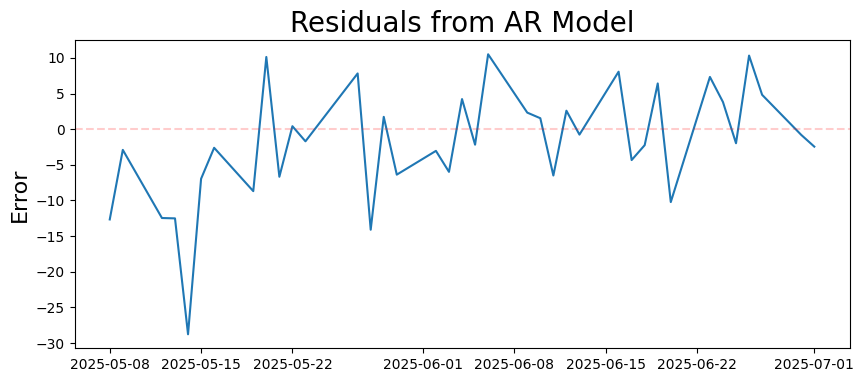

In [247]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

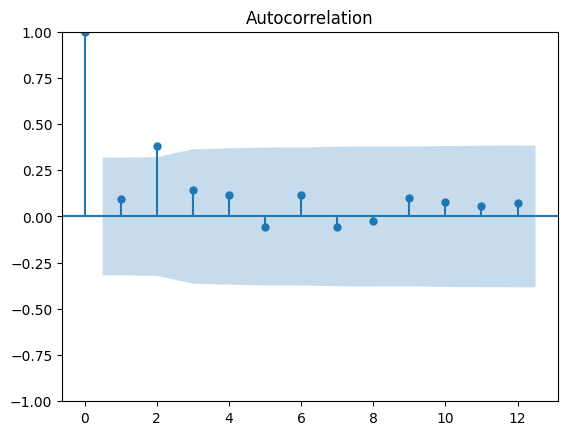

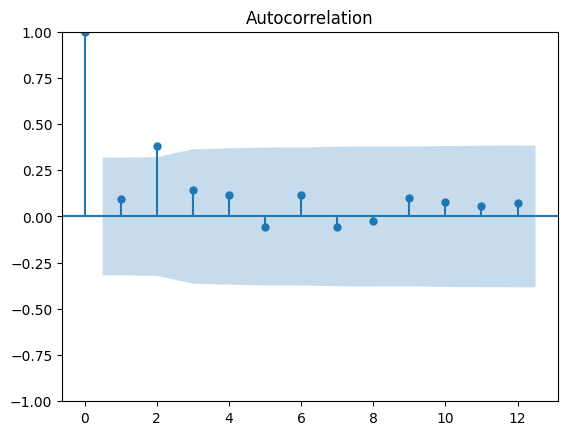

In [248]:
plot_acf(residuals_rolling,lags=12)

In [249]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.05
Root Mean Squared Error: 8.226564454916998


RMSE: 8.226564454916998
MAPE: 0.050035499205952676
MSE: 67.6763627309038
MAE: 6.288525029465558
R^2: 0.8288165965988732


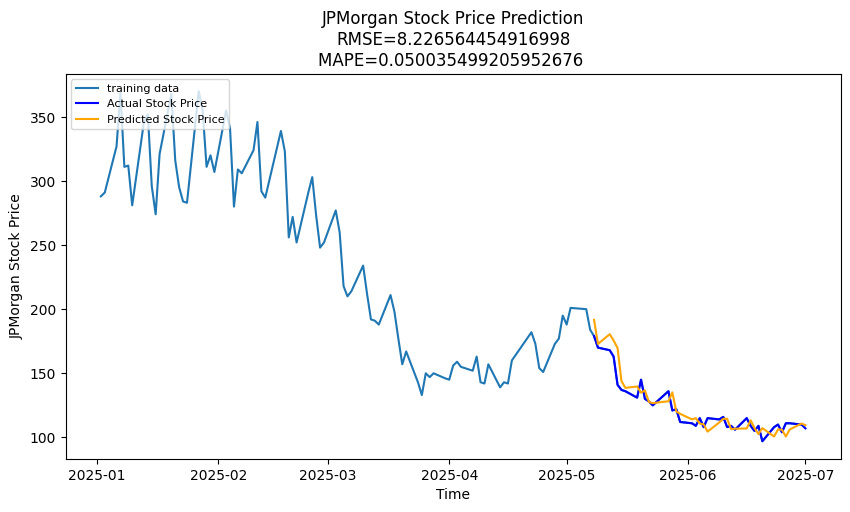

In [250]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
mse = mean_squared_error(np.exp(test_data), np.exp(predictions_rolling))
print('MSE: ' + str(mse))
# 平均绝对误差（MAE）
mae = mean_absolute_error(np.exp(test_data), np.exp(predictions_rolling))
print('MAE: ' + str(mae))
r_squared = r2_score(np.exp(test_data), np.exp(predictions_rolling))
print('R^2:', r_squared)
plt.title('JPMorgan Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [251]:
print(np.exp(predictions_rolling))

2025-05-08    191.662160
2025-05-09    172.902947
2025-05-12    180.461233
2025-05-13    175.512024
2025-05-14    169.770894
2025-05-15    143.957056
2025-05-16    138.610084
2025-05-19    139.691846
2025-05-20    134.869353
2025-05-21    136.676592
2025-05-22    127.582019
2025-05-23    126.702135
2025-05-27    128.180522
2025-05-28    135.105815
2025-05-29    120.271178
2025-05-30    118.377108
2025-06-02    114.042883
2025-06-03    114.985861
2025-06-04    110.775252
2025-06-05    110.175268
2025-06-06    104.492239
2025-06-09    111.675479
2025-06-10    114.462826
2025-06-11    114.500729
2025-06-12    106.406113
2025-06-13    106.762148
2025-06-16    106.936192
2025-06-17    113.331274
2025-06-18    107.240515
2025-06-19    102.586702
2025-06-20    107.225960
2025-06-23    100.670827
2025-06-24    106.193837
2025-06-25    105.973501
2025-06-26    100.673684
2025-06-27    106.179256
2025-06-30    110.803425
2025-07-01    109.447973
dtype: float64


In [252]:
directory = r"C:\Users\ROG\Desktop\so this is the sadness\MINI Project\Data"
filename = "JPMorgan_Stock_Predictions.csv"
file_path = os.path.join(directory, filename)

# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(directory):
    os.makedirs(directory)

In [253]:
predictions_df = pd.DataFrame(np.exp(predictions_rolling), columns=['Predicted'])

In [254]:
# 如果您还想包括训练数据
train_data_df = pd.DataFrame(np.exp(train_data), columns=['Train'])
full_data = train_data_df.join(predictions_df)

# 保存包括训练数据的完整数据
full_data.to_csv('"C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/JPMorgan_Stock_Full_Data.csv', date_format='%Y-%m-%d')

OSError: Cannot save file into a non-existent directory: '"C:\Users\ROG\Desktop\so this is the sadness\MINI Project\Data'